# CNN (Part 2)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# convolution function
from scipy.signal import convolve2d
#  to read image from url
from imageio import imread
# to display image
from PIL import Image

import torch
import torch.nn.functional as F
import torch.nn as nn

# some info about the model 

from torchsummary import summary

import pandas as pd
import torchvision
import torchvision.transforms as T # provides all the transformations of images
from torch.utils.data import DataLoader, TensorDataset

## Types of layers in CNN 

 - **Convolutional Layer**: Applies a filter to the input to produce a feature map.

 - **Pooling Layer**: Reduces the size of the feature map  and increase receptive field by applying a pooling operation.

 - **Fully Connected Layer**: Prediction (categorical and/or regression).


- With increasing depth : 

 - Image resolution (number of pixels) decreases.

 - Representation resolution (number of filters) increases.

 - Layers are smaller(number of pixels) but wider (number of feature maps)

## CNN on MNIST

**CNN architecture**

![mnistCnn](./assets/cnnMnist.png)

In [2]:
df_train = pd.read_csv('../data/mnist_train.csv')
df_test = pd.read_csv('../data/mnist_test.csv')

In [3]:
data = df_train.values[:, 1:]
labels = df_train.values[:, 0]
data.shape, labels.shape

((60000, 784), (60000,))

In [4]:
dataNorm = data / np.max(data)

In [5]:
dataNorm = dataNorm.reshape(dataNorm.shape[0], 1, 28, 28)
dataNorm.shape

(60000, 1, 28, 28)

In [6]:
dataT = torch.tensor(dataNorm, dtype=torch.float32)
labelsT = torch.tensor(labels, dtype=torch.long)

In [7]:
from sklearn.model_selection import train_test_split
train_data, test_data , train_labels, test_labels = train_test_split(dataT, labelsT, test_size=0.4, random_state=42)

In [8]:
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

In [9]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [10]:
train_loader.dataset.tensors[0].shape

torch.Size([36000, 1, 28, 28])

In [11]:
print(train_loader.dataset.tensors[0].shape.numel())

28224000


## Crate the model

In [18]:
def createMnisNet(printtogle=False):
    class MNISnet(nn.Module):
        def __init__(self,printtogle):
            super().__init__()
             
             # convolutional layers

            self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1, padding=1)
            # out_channels represents the number of feature maps
            # the output will be np.floor((28-5+2*1)/1) + 1 = 26 
            # then we apply max pooling by spatial extent 2*2 so the output will be 26/2 = 13 
            self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=1) 
            # output will be 13-5+2*1 = 11
            # then we apply max pooling by spatial extent 2*2 so the output will be 11/2 = 5
            # in this case we take the floor so the ceiling mode in the max pooling will be False since it give 5 not 6
            
            # Computer number of units in FC layer (number of output of conv2)
            expectSize = np.floor((5+2*0-1)/1) + 1
            expectSize = 20*int(expectSize**2)

            ### fully connected layer
            self.fc1 = nn.Linear(expectSize, 50)
            self.out = nn.Linear(50, 10)
            # togle for printing out our tensorsizes during forward pass
            self.print = printtogle

        def forward(self, x,doBN=False):
            print(f'Input: {x.shape} ') if self.print else None

            # convol -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv1(x),2))
            print(f'Conv1/pool1: {x.shape} ') if self.print else None

            x = F.relu(F.max_pool2d(self.conv2(x),2))
            print(f'Conv2/pool2: {x.shape} ') if self.print else None

            nUnits  = x.shape.numel() / x.shape[0] # number of units 
            #we get it by dividing the total number of units by the batch size to get the number of units per image
            x = x.view(-1,int(nUnits))
            # -1 tells pytorch to infer the first dimension
            # Reshape x to (batch_size, nUnits)
            # we can do that x = x.view(x.shape[0], int(nUnits)) by -1 is automatically and well


            print(f'Vectorized: {x.shape} ') if self.print else None

            # Linear layers
            x = F.relu(self.fc1(x))
            print(f'FC1: {x.shape} ') if self.print else None

            x = self.out(x)
            print(f'Output: {x.shape} ') if self.print else None

            return x

    net = MNISnet(printtogle)
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)
    
    
    return net, lossfun, optimizer    

In [19]:
net, lossfun, optimizer = createMnisNet(printtogle=True)
X,y = next(iter(train_loader))
yHat = net(X)
print(yHat.shape)
print(y.shape)

loss = lossfun(yHat, y)
print(loss)

Input: torch.Size([32, 1, 28, 28]) 
Conv1/pool1: torch.Size([32, 10, 13, 13]) 
Conv2/pool2: torch.Size([32, 20, 5, 5]) 
Vectorized: torch.Size([32, 500]) 
FC1: torch.Size([32, 50]) 
Output: torch.Size([32, 10]) 
torch.Size([32, 10])
torch.Size([32])
tensor(2.2814, grad_fn=<NllLossBackward0>)


In [22]:
summary(net,(1,28,28))

Input: torch.Size([2, 1, 28, 28]) 
Conv1/pool1: torch.Size([2, 10, 13, 13]) 
Conv2/pool2: torch.Size([2, 20, 5, 5]) 
Vectorized: torch.Size([2, 500]) 
FC1: torch.Size([2, 50]) 
Output: torch.Size([2, 10]) 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
            Conv2d-2           [-1, 20, 11, 11]           5,020
            Linear-3                   [-1, 50]          25,050
            Linear-4                   [-1, 10]             510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


In [29]:
import sys
sys.path.append('../utils')
sys.path.append('../models')
import importlib 
import training
importlib.reload(training)
from training import trainTheM0del

In [30]:
num_epochs = 5
model, lossfun, optimizer = createMnisNet(printtogle=False)

In [31]:
losses, train_accuracy, test_accuracy = trainTheM0del(
        isClassification=True,
        optimizer = optimizer,
        doBN=False,
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        num_epochs=num_epochs,
        loss_function= lossfun)

Epoch 1/5, Train Loss: 0.2908, Train Acc: 91.12, Test Acc: 96.75
Epoch 2/5, Train Loss: 0.0847, Train Acc: 97.36, Test Acc: 97.76
Epoch 3/5, Train Loss: 0.0596, Train Acc: 98.13, Test Acc: 98.03
Epoch 4/5, Train Loss: 0.0459, Train Acc: 98.54, Test Acc: 98.37
Epoch 5/5, Train Loss: 0.0382, Train Acc: 98.78, Test Acc: 98.52


In [ ]:
class gauseNet(nn.Module):
        def __init__(self,k,s,p):
            super().__init__()

            self.k = k
            self.s = s
            self.p = p


            self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=k, stride=s, padding=p)

            # output of the convolution layer
            imsizeW = np.floor((91+2*self.p[0]-k[0])/s[0]) + 1
            imsizeW = np.floor(imsizeW/2) # pooling
            imsizeH = np.floor((91+2*self.p[1]-k[1])/s[1]) + 1
            imsizeH = np.floor(imsizeH/2) # pooling

            self.conv2 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=k, stride=s, padding=p)

            # output of the convolution layer
            imsizeW = np.floor((imsizeW+2*self.p[0]-k[0])/s[0]) + 1
            imsizeW = np.floor(imsizeW/2) # pooling
            imsizeH = np.floor((imsizeH+2*self.p[1]-k[1])/s[1]) + 1
            imsizeH = np.floor(imsizeH/2) # pooling

            # fc1 
            
            expectSize = imsizeW*imsizeH*self.conv2.out_channels

            self.fc1 = nn.Linear(expectSize, 50)
            self.out = nn.Linear(50, 1)


## CNN Auto-encoder on gaussian noise

In [45]:
# create Gaussian blurs with varying width and occulding bars
nGauss = 1000
imgSize = 91
x =  np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# varying the weights smoothly
widths = np.linspace(2,20,nGauss)
# initialize tensor containing images
images = torch.zeros((nGauss,1,imgSize,imgSize))

for i in range(nGauss):
    
    # create the gaussian with random centers 
    ro = 1.5*np.random.randn(2) # ro = random offset
    G = np.exp(-((X-ro[0])**2 + (Y-ro[1])**2)/widths[i])

    # add noise

    G = G + np.random.randn(imgSize,imgSize)/5
    
    # add random bar randomly 
    i1 = np.random.choice(np.arange(2,28))
    i2 = np.random.choice(np.arange(2,6))

    if np.random.randn()>0:
        G[i1,i1+i2,]=1
    else:
        G[:,i1:i1+i2]=1   

    images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)         


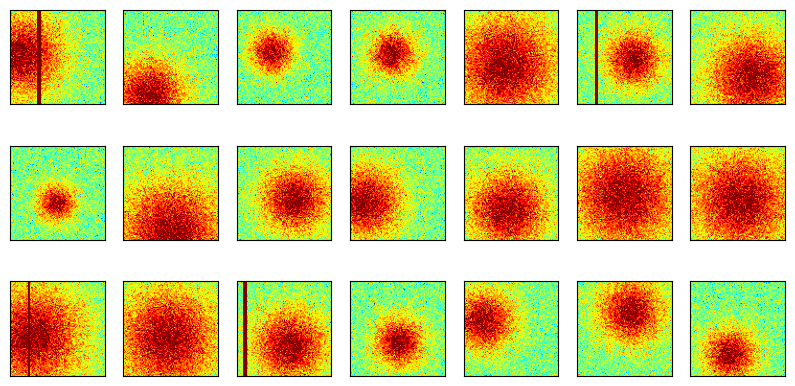

In [46]:
fig,axs = plt.subplots(3,7,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss)
    G = np.squeeze(images[whichpic,:,:,:])
    ax.imshow(G,cmap='jet',vmin=-1,vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


In [47]:
def createGaussNet():

    class GaussAutoencoder(nn.Module):
        def __init__(self):
            super().__init__()


            self.enc = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(in_channels=6,out_channels=4,kernel_size=3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )

            self.dec = nn.Sequential(

              nn.ConvTranspose2d(in_channels=4,out_channels=6,kernel_size=3,stride=2),
              nn.ReLU(),
              nn.ConvTranspose2d(in_channels=6,out_channels=1,kernel_size=3,stride=2),

            )

        def forward(self,x):
            x = self.enc(x)
            x = self.dec(x)
            return x

    net = GaussAutoencoder()
    lossfun = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)
    
    return net, lossfun, optimizer        


In [56]:
def trainTheModel():
    num_epochs = 10000
    net, lossfun, optimizer = createGaussNet()
    losses = torch.zeros(num_epochs)

    for epochi in range(num_epochs):
        # pick 32 random images
        pics2use = np.random.choice(nGauss,size=32,replace=False)
        X = images[pics2use,:,:,:] 

        # forward pass and loss

        yHat = net(X)
        loss = lossfun(yHat,X)
        losses[epochi] = loss.item()

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        

    return losses,net  

In [57]:
losses,net = trainTheModel()

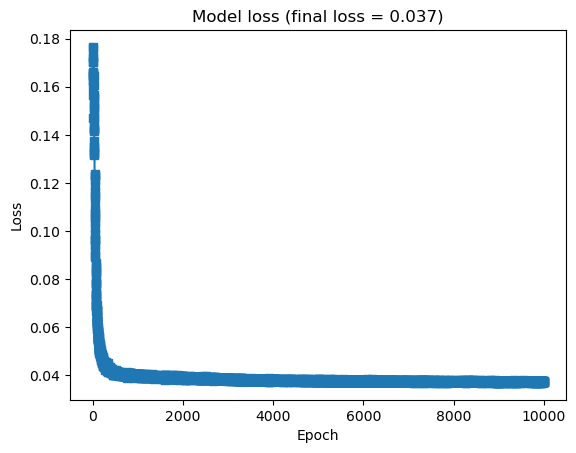

In [58]:
plt.plot(losses, 's-', label='Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Model loss (final loss = {losses[-1]:.3f})')
plt.show()

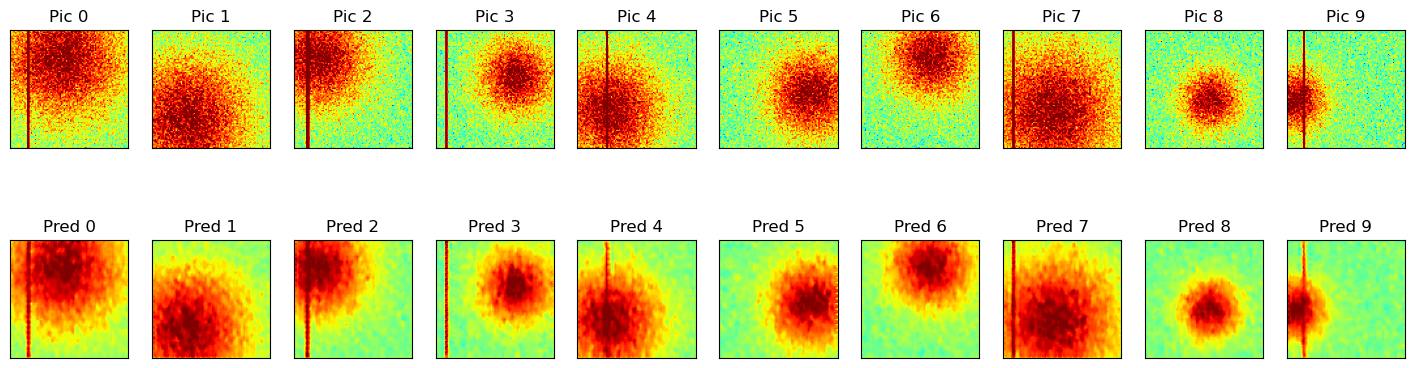

In [59]:
pic2use = np.random.choice(nGauss,size=32,replace=False)
X = images[pic2use,:,:,:]
predections = net(X)

fig,axs = plt.subplots(2,10,figsize=(18,5))

for i in range(10):
    G = torch.squeeze(X[i,:,:,:]).detach()
    ax = axs[0,i]
    ax.set_title(f'Pic {i}')
    ax.imshow(G,cmap='jet',vmin=-1,vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])

    G = torch.squeeze(predections[i,:,:,:]).detach()
    ax = axs[1,i]
    ax.set_title(f'Pred {i}')
    ax.imshow(G,cmap='jet',vmin=-1,vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()